# Multi objective optimization post-processing analysis

In [25]:
using Revise
using FUSE
using IMAS
using JLD2
using Plots;
using Metaheuristics;
gr();

## Process data

### Choose run directory

In [26]:
#result_path = "study_1/opt_betaN_cost__Solovev_Paux30_flattop24/"; run_dir = "gen_runs3"
#result_path = "study_1/opt_betaN_cost__Solovev_Paux30_flattop48/"; run_dir = "gen_runs6"
#result_path = "study_1/opt_betaN_cost__Solovev_Paux30_flattop72/"; run_dir = "gen_runs5"

#result_path = "study_1/opt_betaN_R0__Solovev_Paux30_flattop24/"; run_dir = "gen_runs3"
#result_path = "study_1/opt_betaN_R0__Solovev_Paux30_flattop48/"; run_dir = "gen_runs6"
#result_path = "study_1/opt_betaN_R0__Solovev_Paux30_flattop72/"; run_dir = "gen_runs6"

#result_path = "study_1/opt_betaN_cost__Solovev_flattop24/"; run_dir = "gen_runs6"
#result_path = "study_1/opt_betaN_cost__Solovev_flattop48/"; run_dir = "gen_runs4"
result_path = "study_1/opt_betaN_cost__Solovev_flattop72/"; run_dir = "gen_runs2"

#result_path = "study_1/opt_betaN_cost__TEQUILA_Paux30_flattop48/"; run_dir = "gen_runs4"

#result_path = "study_1/opt_betaN_cost__Solovev_Paux30_Bt5.0_flattop48/"; run_dir = "gen_runs3"
#result_path = "study_1/opt_betaN_cost__Solovev_Paux30_Bt6.0_flattop48/"; run_dir = "gen_runs6"
#result_path = "study_1/opt_betaN_cost__Solovev_Paux30_Bt7.0_flattop48/"; run_dir = "gen_runs5"


"gen_runs2"

### Read and/or write cache

In [27]:

cache_path = joinpath(result_path, run_dir)
all_dirs = filter(isdir, sort(readdir(cache_path; join=true)))
println(length(all_dirs))

dirs = sort(filter(x -> !isfile(joinpath(x, "error.txt")), all_dirs))
println(length(dirs))

IMAS.update_ExtractFunctionsLibrary!(); # to pick up any ongoing development to extract function library
outputs = FUSE.extract(dirs; filter_invalid=:cols, cache=joinpath(cache_path, "extract.csv"), read_cache=true, write_cache=true);


64
64


Progress: 100%|███████████████████████████| Time: 0:00:16 ( 0.26  s/it)
[ Info: Written cache file with 64 results


In [28]:
outputs[:,"nGW"] = outputs[:,"ip"] ./ (π .* outputs[:,"a"].^2) * 1e20
outputs[:,"fGW_ped"] = outputs[:,"ne_ped"] ./ outputs[:,"nGW"];


In [29]:
dd, ini, act = FUSE.load(dirs[end]);

┌ Error: reading act.ActorDivertors.impurities : TypeError(:setfield!, "", Union{Missing, Function, Vector{Symbol}}, Float64[])
└ @ SimulationParameters ~/.julia/dev/SimulationParameters/src/utils.jl:92


## Analyze Optimzation results

### Load optimization results file

In [30]:
con = []

for i in range(1,6)

    fname = "result"*string(i)*".jld2"

    try
        @load joinpath(result_path, fname) result
        display("Loaded "*fname)
        for c in result.convergence
            con = [con; c]
        end

    catch
        display("Could not find "*fname)
    end

end

@load joinpath(result_path, "opt_ini.jld2") opt_ini



"Loaded result1.jld2"

"Loaded result2.jld2"

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 ~/.julia/packages/JLD2/cHcDY/src/JLD2.jl:287


"Could not find result3.jld2"

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 ~/.julia/packages/JLD2/cHcDY/src/JLD2.jl:287


"Could not find result4.jld2"

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 ~/.julia/packages/JLD2/cHcDY/src/JLD2.jl:287


"Could not find result5.jld2"

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 ~/.julia/packages/JLD2/cHcDY/src/JLD2.jl:287


"Could not find result6.jld2"

1-element Vector{Symbol}:
 :opt_ini

### Parse opt_ini data

In [31]:
fnames = []
for obj_func in opt_ini["objective_functions"]
    name = string(obj_func.name)*"_"
    #display(name)
    fnames = [fnames; name]
end
display(fnames)

gnames = []
for con_func in opt_ini["constraint_functions"]
    name = string(con_func.name)
    #display(name)
    gnames = [gnames; name]
end
display(gnames)

xnames = []
for param in opt_ini["free_parameters"]
    name = string(param._name)
    #display(name)
    xnames = [xnames; name]
end
display(xnames)

2-element Vector{Any}:
 "min_capital_cost_"
 "min_βn_"

10-element Vector{Any}:
 "min_required_power_electric_net"
 "min_required_flattop"
 "max_ωpe_ωce"
 "min_lh_power_threshold"
 "max_hds03"
 "max_ne_peaking"
 "max_tf_j"
 "max_oh_j"
 "max_tf_stress"
 "max_oh_stress"

8-element Vector{Any}:
 "B0"
 "R0"
 "pressure_core"
 "ip"
 "greenwald_fraction"
 "ne_coreped_ratio"
 "zeff"
 "power_launched"

### Organize results into dict arrays

In [32]:
db = Dict()
pf = []

# loop over number of generations
for i in 1:1:length(con)
    A = pareto_front(con[i])
    B = con[i].population
    
    # get input values, objective values, and constraint values
    pop_x = reduce(hcat, [j.x for j in B])'
    pop_f = reduce(hcat, [j.f for j in B])'
    pop_g = reduce(hcat, [j.g for j in B])'
    
    # populate objective values 
    for (j,fname) in enumerate(fnames)
        try
            db[fname[5:end]] = hcat(db[fname[5:end]], pop_f[:,j])
        catch
            db[fname[5:end]] = pop_f[:,j]
        end
    end
    
    # populate input values with scale factor
    for (j,xname) in enumerate(xnames)
        try
            db[xname] = hcat(db[xname], pop_x[:,j])
        catch
            db[xname] = pop_x[:,j]
        end
    end
    
    # populate constraint values with conversion factor
    for (j,gname) in enumerate(gnames)
        try
            db[gname[5:end]] = hcat(db[gname[5:end]], pop_g[:,j])
        catch
            db[gname[5:end]] = pop_g[:,j]
        end
    end
    
    # find indices of Pareto-optimal solutions
    #index = zeros(Int,length(B))
    pfi = [findfirst(isequal(a), db[fnames[1][5:end]][:,i]) for a in A[:,1]]
    #index[pfi] .= 1
    pf = [pf; [pfi]]

end


In [33]:
keys(db)

KeySet for a Dict{Any, Any} with 20 entries. Keys:
  "oh_j"
  "lh_power_threshold"
  "ip"
  "tf_j"
  "ωpe_ωce"
  "ne_peaking"
  "hds03"
  "power_launched"
  "greenwald_fraction"
  "ne_coreped_ratio"
  "required_power_electric_net"
  "pressure_core"
  "oh_stress"
  "required_flattop"
  "βn_"
  "capital_cost_"
  "R0"
  "tf_stress"
  "B0"
  "zeff"

### Rescale constraint values

In [34]:
ini.requirements

requirements{Float64}
├─ power_electric_net ➡ 2.0e8 [W] Net electric power generated by the fusion power plant
├─ flattop_duration ➡ 259200.0 [s] Duration of the flattop (use Inf for steady-state)
├─ log10_flattop_duration ➡ missing Log10 value of the duration of the flattop (use Inf for steady-state). Preferred over
│  `flattop_duration` for optimization studies.
├─ tritium_breeding_ratio ➡ 1.1 Tritium breeding ratio of the whole plant
├─ cost ➡ missing Total FPP cost
├─ ne_peaking ➡ 1.5 On-axis electron density / volume-averaged electron denstiy
├─ q_pol_omp ➡ 2.75e9 [W/m^2] Poloidal heat flux at the outer midplane
├─ lh_power_threshold_fraction ➡ 1.0 Fraction of the LH power threshold
├─ h98y2 ➡ missing H98y2 ITER elmy H-mode confinement scaling factor
├─ hds03 ➡ 1.0 Petty 2003 H-mode thermal energy confinement scaling factor
├─ βn ➡ missing Normalized total plasma beta (MHD)
├─ coil_j_margin ➡ 1.5 Magnet coil J_crit / J_max
└─ coil_stress_margin ➡ 1.0 Magnet coil yield_stress / max

In [35]:
# re-scale constraint values

function scale_max_constraint(value, limit)
    return limit .* (1 .+ value)
end

function scale_min_constraint(value, limit)
    return limit .* (1 .- value)
end

for gname in gnames

    limit = missing

    # get min/max value from dd for common constraints
    if gname == "min_required_power_electric_net"
        limit = ini.requirements.power_electric_net
    elseif gname == "max_ωpe_ωce"
        limit = 1.0
    elseif gname == "min_lh_power_threshold"
        limit = ini.requirements.lh_power_threshold_fraction
    elseif gname == "max_hds03"
        limit = ini.requirements.hds03
    elseif gname == "max_ne_peaking"
        limit = ini.requirements.ne_peaking
    elseif gname == "max_tf_j" || gname == "max_oh_j"
        limit = ini.requirements.coil_j_margin
    elseif gname == "max_tf_stress" || gname == "max_oh_stress"
        limit = ini.requirements.coil_stress_margin
    elseif gname == "max_qpol_omp"
        limit = ini.requirements.q_pol_omp
    elseif gname == "min_required_flattop"
        limit = ini.requirements.flattop_duration
    end

    # scale 
    if occursin("max", gname)
        db[gname[5:end]] = scale_max_constraint(db[gname[5:end]], limit)
    elseif occursin("min", gname)
        db[gname[5:end]] = scale_min_constraint(db[gname[5:end]], limit)
    end

end

## Visualize Optimization results

### Plot f, x, g evolution

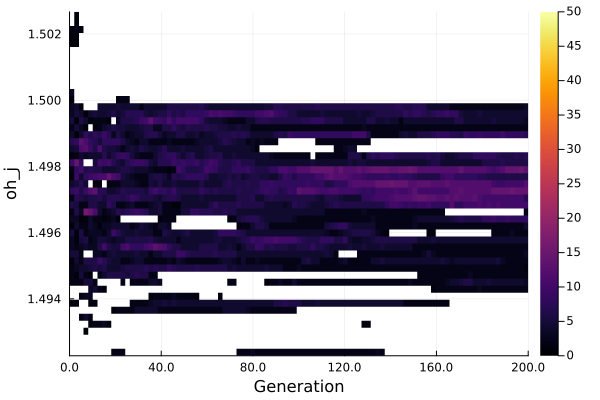

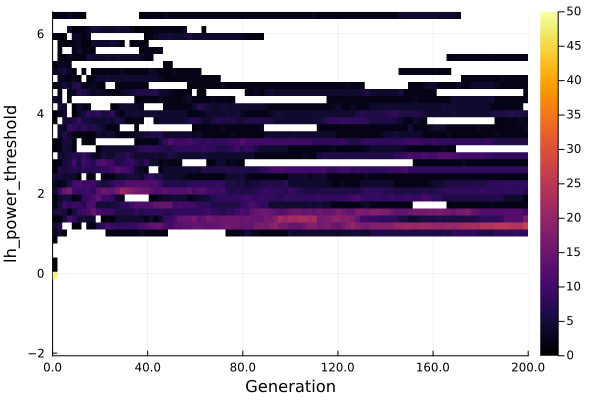

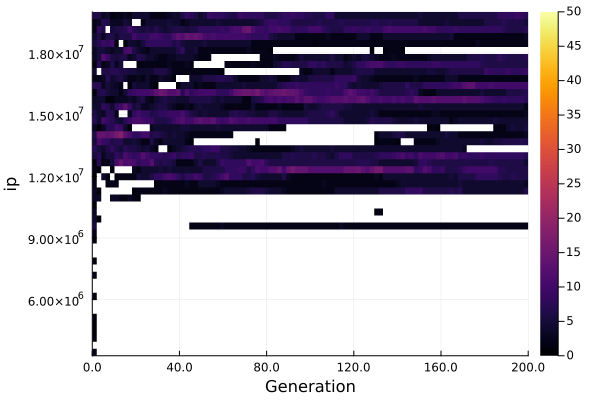

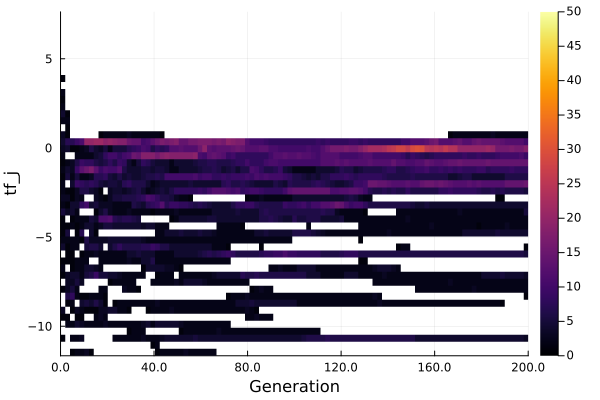

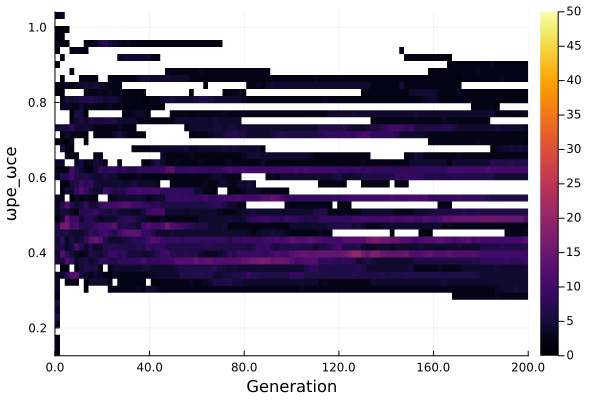

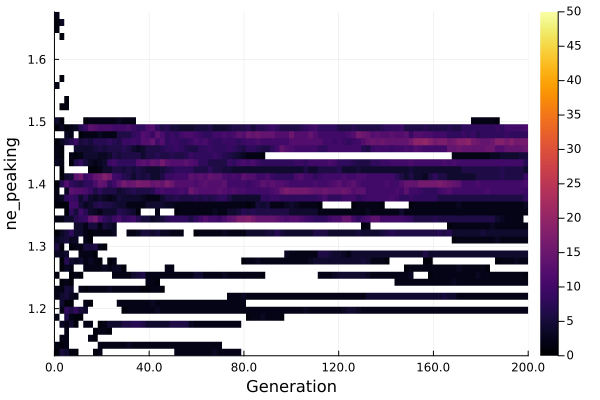

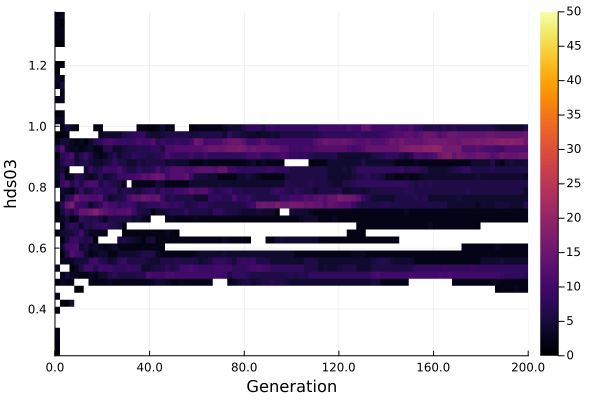

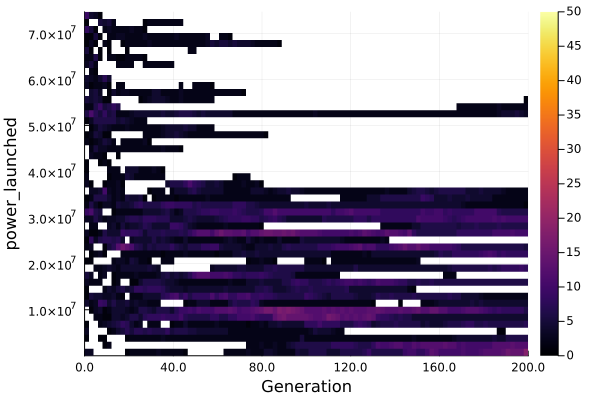

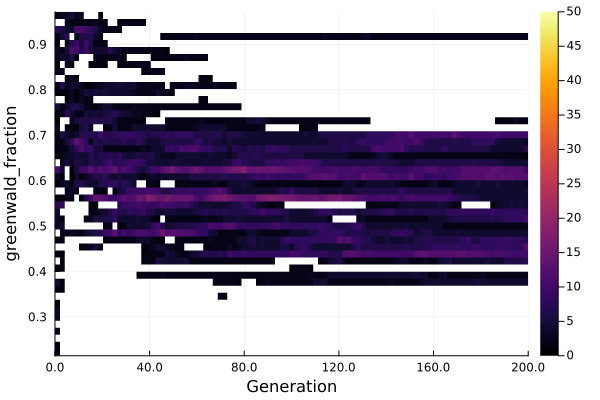

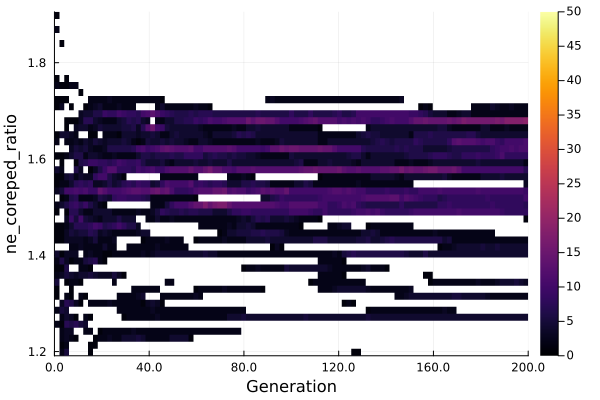

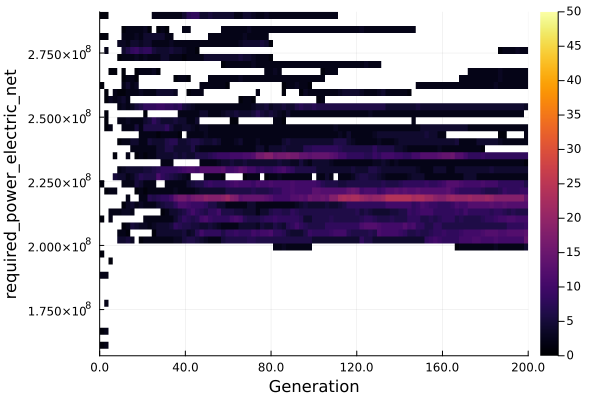

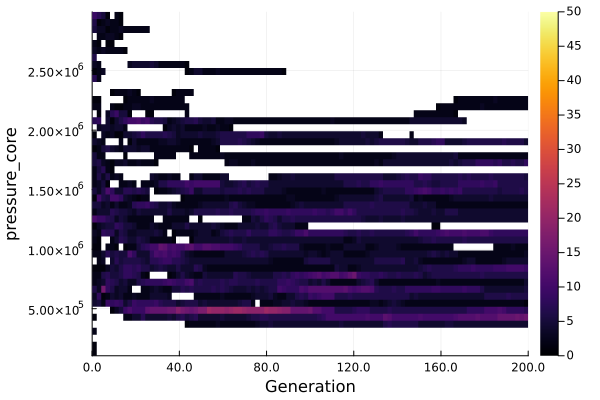

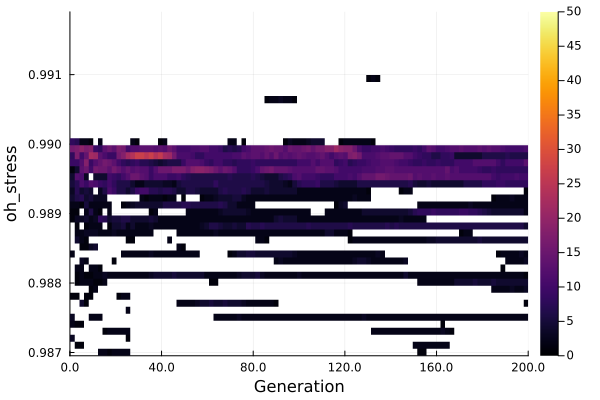

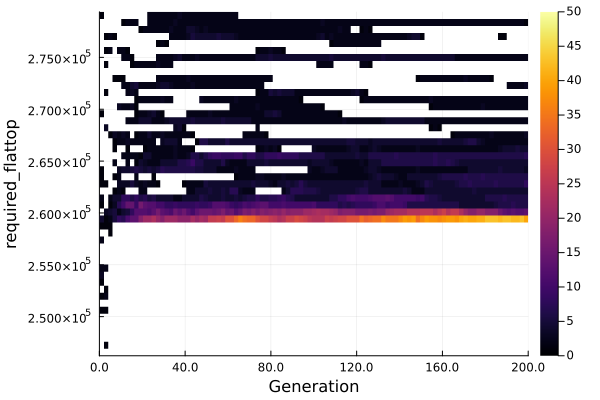

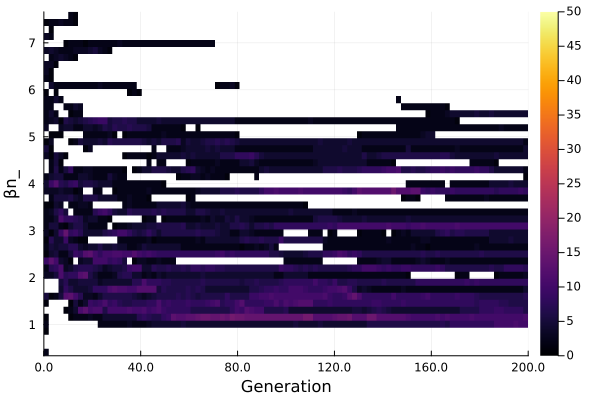

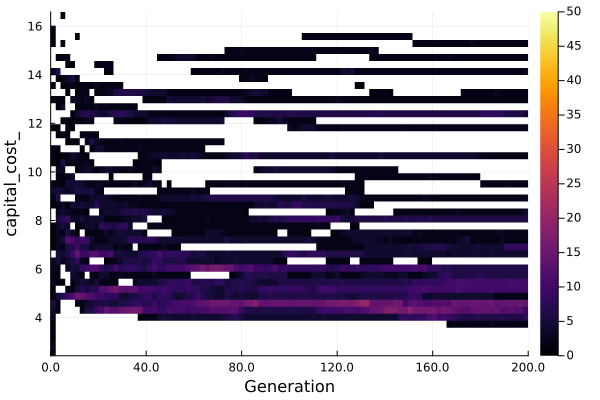

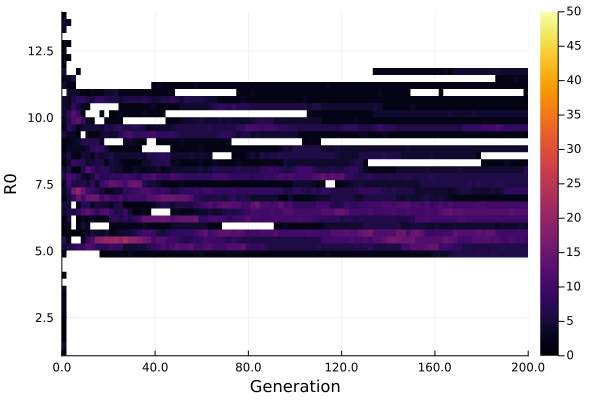

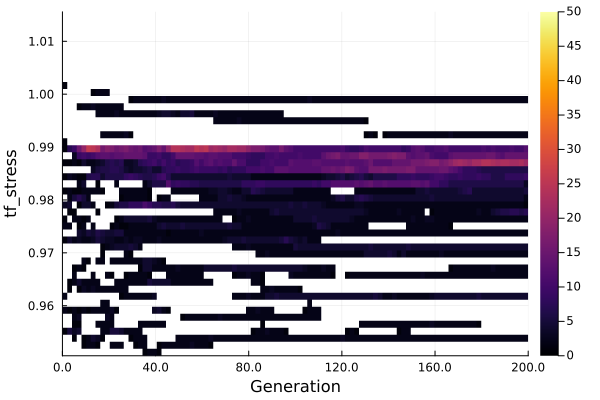

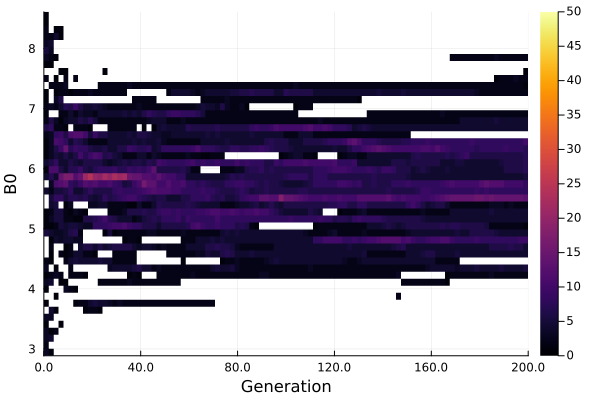

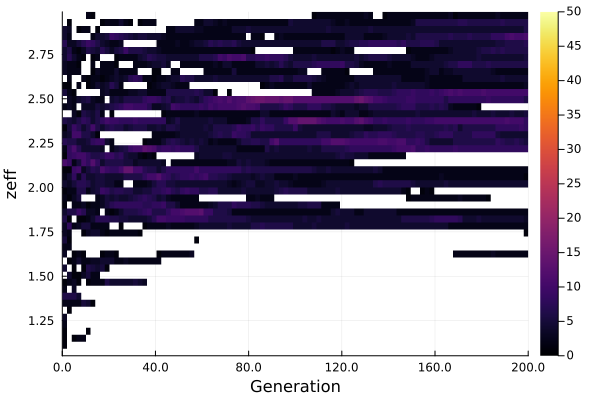

In [36]:
import Statistics
function y_auto_range(y; σ=5, N=50)
    y_nonan = y[@. !isnan.(y)]
    m = Statistics.median(y_nonan)
    s = Statistics.median(Statistics.median(abs.(y_nonan .- m))) * σ
    Y = LinRange(max(m - s, minimum(y_nonan)), min(m + s, maximum(y_nonan)), N)
end

clim = (0,50)
N = 5

for var in keys(db)
    
    y = db[var]
    ngen = size(y)[2]
    X = LinRange(1,length(y),Int(round(ngen/2)))
    yname = var
    
    yflat = vcat(y...)
    Y = y_auto_range(yflat)
    
    p = histogram2d(yflat, bins=(X, Y), ylabel=yname, xlabel="Generation", clim=clim)
    xticks!(LinRange(0,length(y),N+1),[string(x) for x in (LinRange(0,ngen,N+1))])
    display(p)

end



In [37]:
keys(db)

KeySet for a Dict{Any, Any} with 20 entries. Keys:
  "oh_j"
  "lh_power_threshold"
  "ip"
  "tf_j"
  "ωpe_ωce"
  "ne_peaking"
  "hds03"
  "power_launched"
  "greenwald_fraction"
  "ne_coreped_ratio"
  "required_power_electric_net"
  "pressure_core"
  "oh_stress"
  "required_flattop"
  "βn_"
  "capital_cost_"
  "R0"
  "tf_stress"
  "B0"
  "zeff"

### Define function for scatter plot of ith generation

In [38]:
function scatter_gen(
        db, pf,
        igen,xlabel,ylabel,
        xrange,yrange; 
        s=missing,
        cp=:red,
        c=:grey,
        l=missing)
    
    x = db[xlabel][:,igen]
    y = db[ylabel][:,igen]
    
    xpf = x[pf[igen]]
    ypf = y[pf[igen]]

    if ismissing(s)
        s = plot()
    end
    
    if ismissing(l)
        l1 = "Population"
        l2 = "Pareto-optimal"
        title = "Generation: "*string(igen)
    else
        l1 = ""
        l2 = l
        title = ""
    end

    scatter!(s, x, y, color=c, label=l1, alpha=0.7)
    scatter!(s, xpf, ypf, color=cp, label=l2)
    plot!(s, size=(450, 450), title=title, xlabel=xlabel, ylabel=ylabel, xrange=xrange, yrange=yrange) 
    
end

scatter_gen (generic function with 1 method)

### Make gif of population evolution

[ Info: Saved animation to /fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/playground/weisberg_FPP_opt/study_1/opt_betaN_cost__Solovev_flattop72/βn__capital_cost_.gif


Plots.AnimatedGif("/fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/playground/weisberg_FPP_opt/study_1/opt_betaN_cost__Solovev_flattop72/βn__capital_cost_.gif")
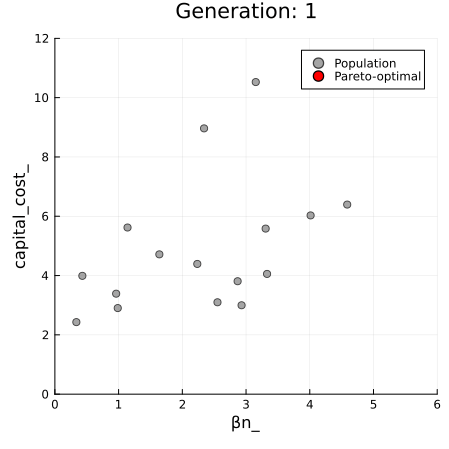

In [39]:
xlabel = "βn_"
xrange = (0,6)

ylabel = "capital_cost_"
yrange = (0.0, 12.0)

#ylabel = "R0"
#yrange = (0.0, 15)

#ylabel = "B0"
#yrange = (3.0, 10)

#ylabel = "greenwald_fraction"
#yrange = (0.3,1.3)

gen_list = 1:1:length(con)
gen_list = vcat(gen_list,repeat([length(con)],100))

a = @animate for igen in gen_list
    s = scatter_gen(db, pf, igen, xlabel, ylabel, xrange, yrange)
end

g = gif(a, joinpath(result_path, xlabel*"_"*ylabel*".gif"), fps=30)
display(g)


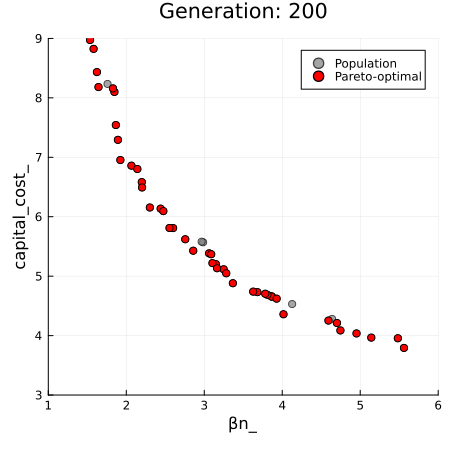

In [40]:
# static plot of objective functions

igen = gen_list[end]

xrange = (1,6)
yrange = (3,9)

s = scatter_gen(db, pf, igen, fnames[2][5:end], fnames[1][5:end], xrange, yrange)
display(s)

### Plot free parameters

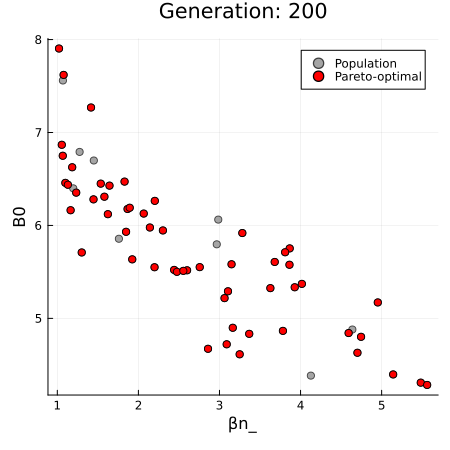

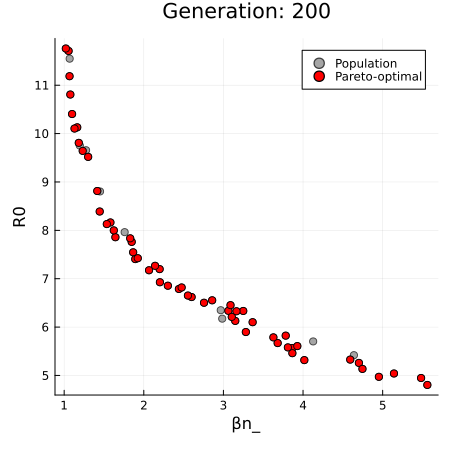

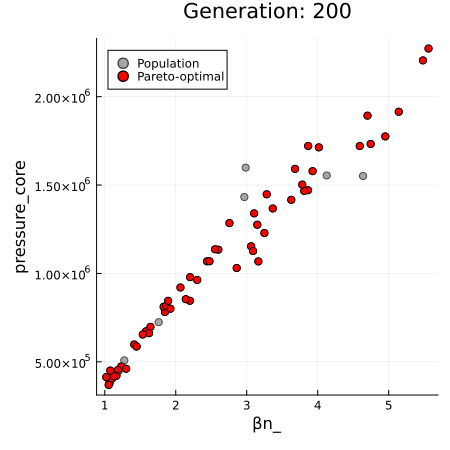

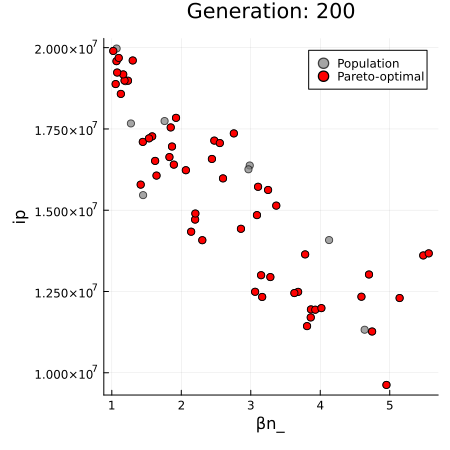

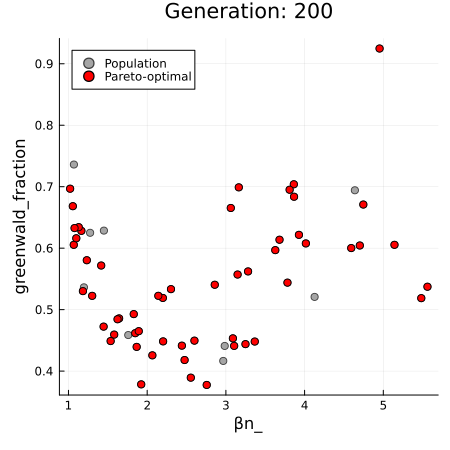

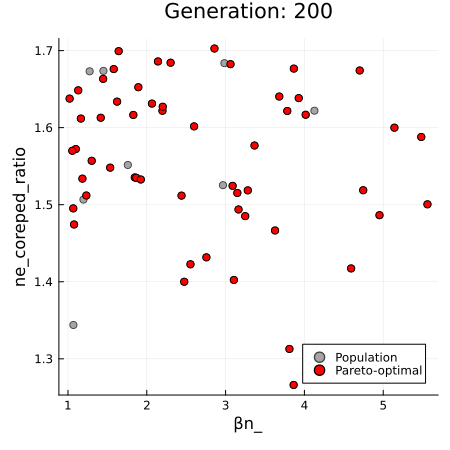

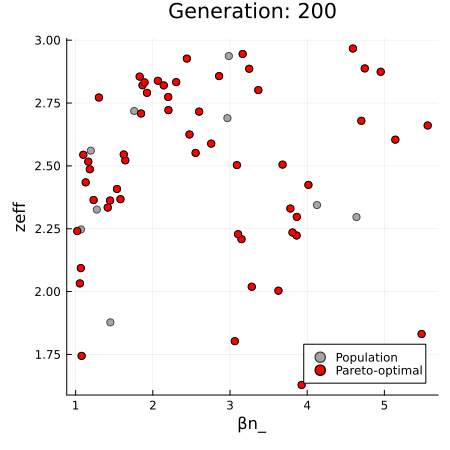

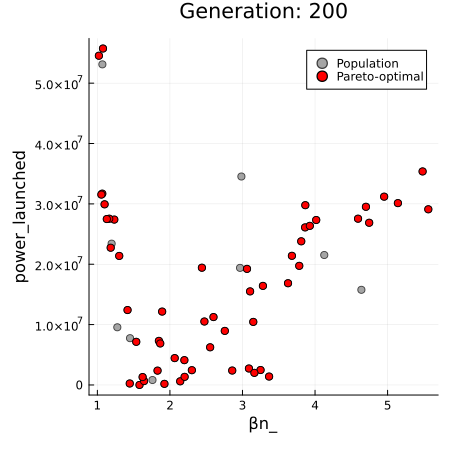

In [41]:
xlabel = "βn_"

for ylabel in xnames

    xrange = :missing
    yrange = :missing

    #yrange = (0,15)

    igen = gen_list[end]

    s = scatter_gen(db, pf, igen, xlabel, ylabel, xrange, yrange)
    display(s)

end

### Plot constrained parameters

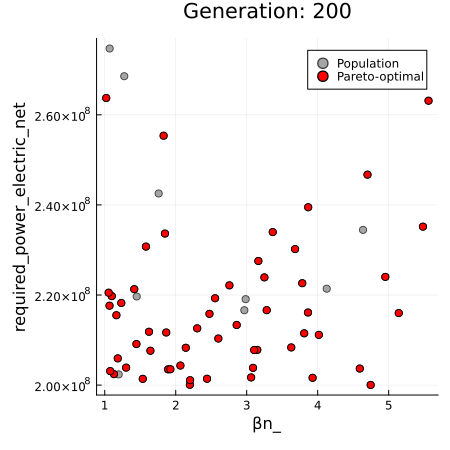

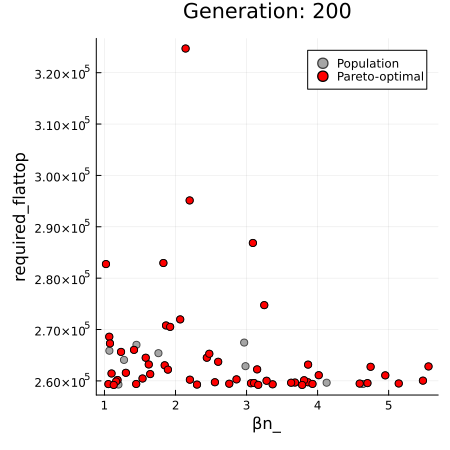

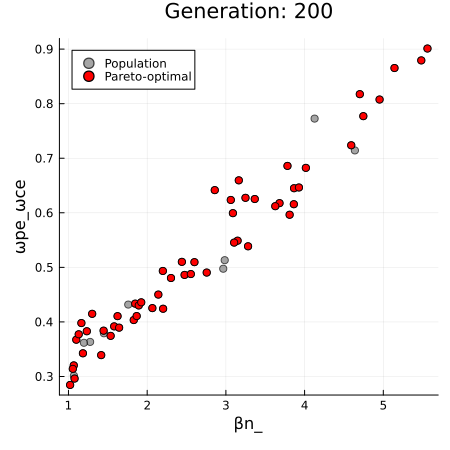

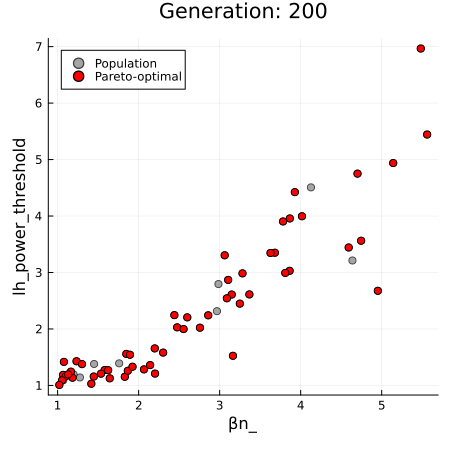

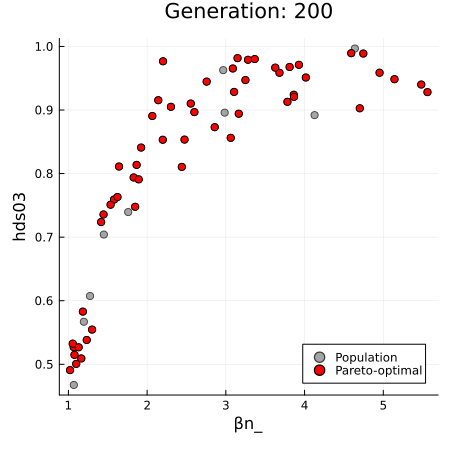

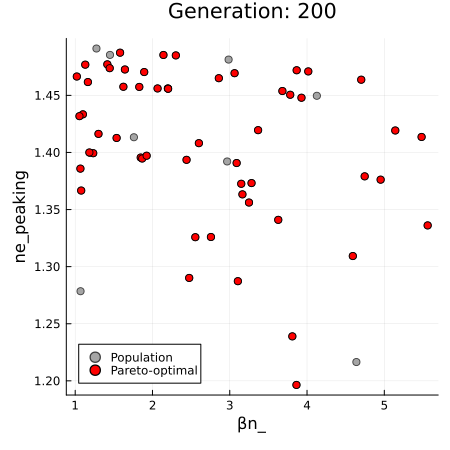

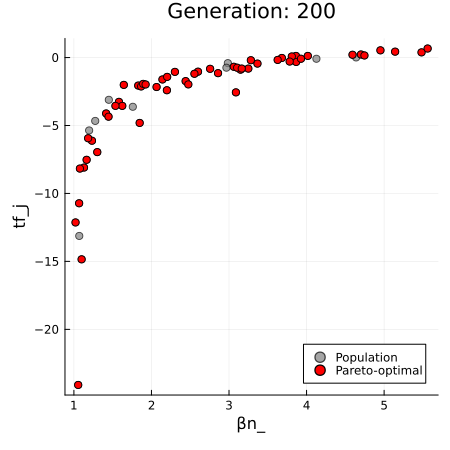

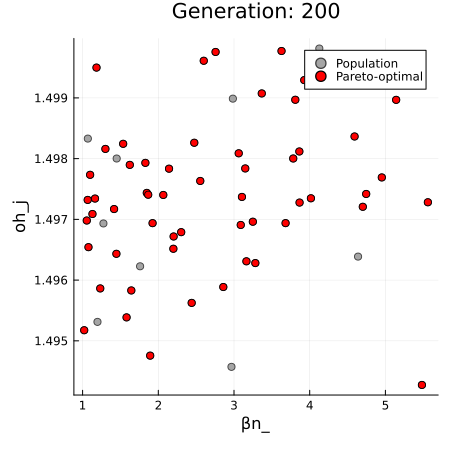

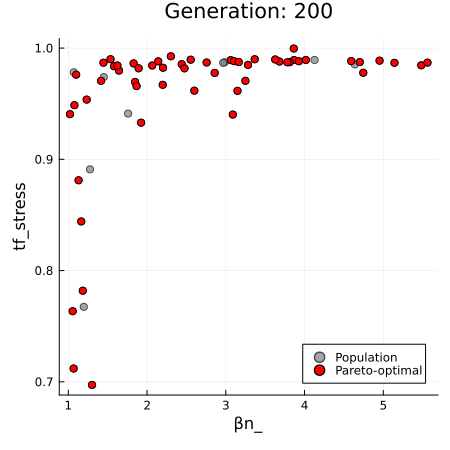

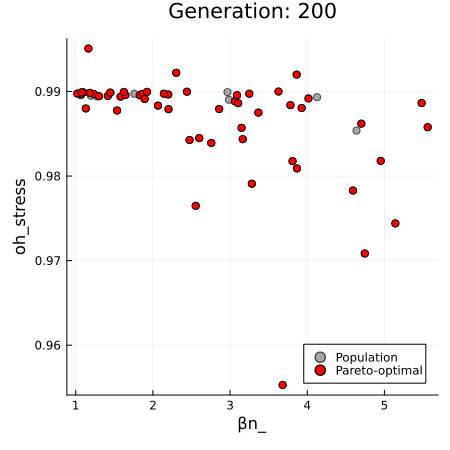

In [42]:
xlabel = "βn_"

for ylabel in gnames

    xrange = :missing
    yrange = :missing

    #yrange = (0,15)

    igen = gen_list[end]

    s = scatter_gen(db, pf, igen, xlabel, ylabel[5:end], xrange, yrange)
    display(s)

end

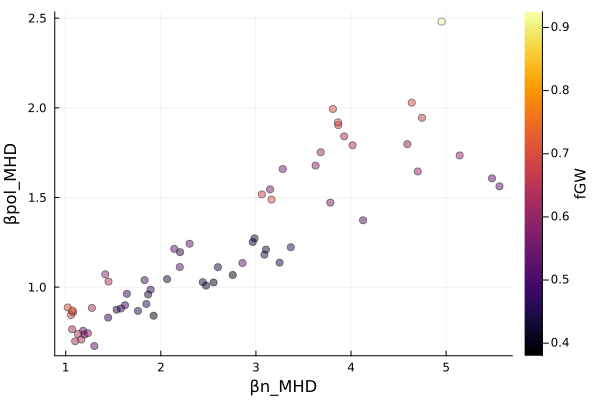

In [43]:
xname = "βn_MHD"
#xname = "B0"

yname = "βpol_MHD"
#yname = "PBp/R0"
#yname = "flattop"
#yname = "qpol"
#yname = "OH_max_b"
#yname = "q95"
#yname = "βtor_MHD"
#yname = "<P>"
#yname = "B0"
#yname = "R0"
#yname = "ip"
#yname = "Paux_tot"
#yname = "Hds03"
zname = "fGW"

x = outputs[:,xname]
y = outputs[:,yname]

scatter(x, y, zcolor=outputs[:,zname],
    markershape=:circle, color=:black, alpha=0.5,
    xlabel=xname, ylabel=yname, colorbar_title=zname, label="")




In [44]:
0.04/(0.5*(1+2.15^2))

0.014228546020453536

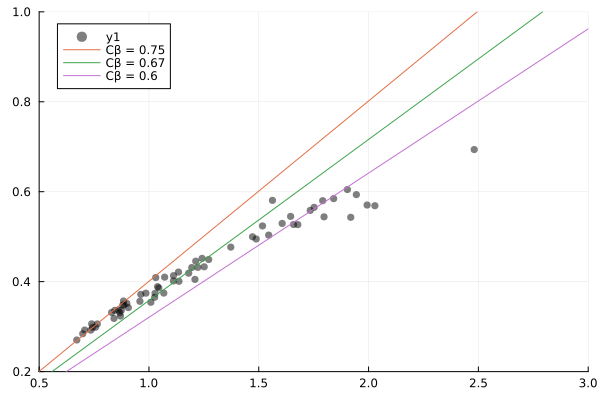

In [45]:
s = scatter(outputs[:,"βpol_MHD"],outputs[:,"ip_bs"]./outputs[:,"ip_bs_aux_ohm"],markershape=:circle,color=:black, alpha=0.5)
x = LinRange(0,3,55)
plot!(s,x,0.75*x/sqrt(3.5),label="Cβ = 0.75")
plot!(s,x,0.67*x/sqrt(3.5),label="Cβ = 0.67")
plot!(s,x,0.6*x/sqrt(3.5),label="Cβ = 0.6")
plot!(s,xrange=(0.5,Inf),yrange=(0.2,1.0))

In [46]:
Psol_ITER = 100e6
Bpol_ITER = IMAS.Bpol(2.0, 1.85, 15.0 * 1e6)
PBpR_ITER = Psol_ITER/1e6 * Bpol_ITER/6.2


16.269741278350875

In [47]:

lambdaq_ITER = IMAS.widthSOL_eich(6.2, 2.0, Bpol_ITER, Psol_ITER)
qpol_ITER = Psol_ITER / (2π * (6.2+2.0) * lambdaq_ITER )

2.375851565452507e9

### Multiplot for IAEA

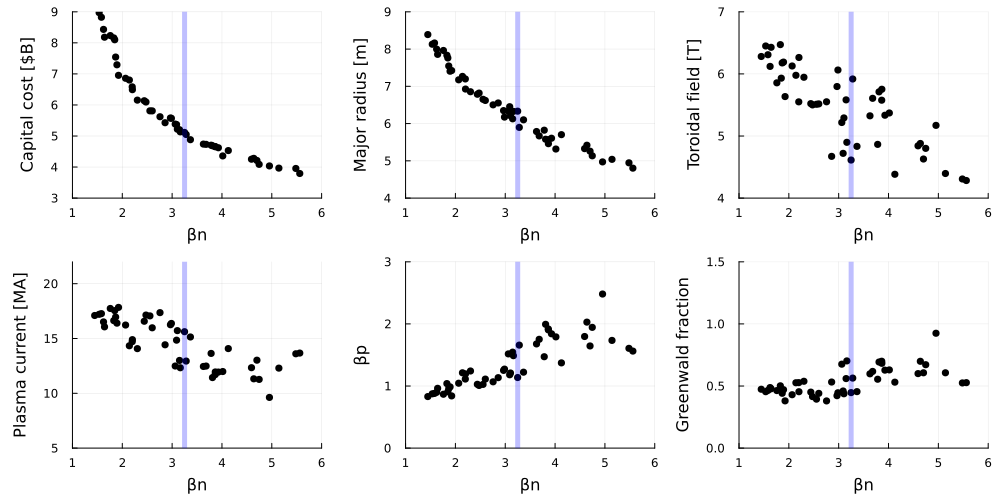

In [48]:
using Plots.PlotMeasures

xname = "βn_MHD"

yname1 = "capital_cost"
yname2 = "R0"
yname3 = "B0"
yname4 = "ip"
yname5 = "βpol_MHD"
yname6 = "fGW"

iplot = outputs[:,"capital_cost"] .< 10.0

x = outputs[:,xname][iplot]
y1 = outputs[:,yname1][iplot]
y2 = outputs[:,yname2][iplot]
y3 = outputs[:,yname3][iplot]
y4 = outputs[:,yname4][iplot]
y5 = outputs[:,yname5][iplot]
y6 = outputs[:,yname6][iplot]

p1 = scatter(
    x, y1, 
    markershape=:circle, color=:black, yrange=(3,9),
    xlabel="βn", ylabel="Capital cost [\$B]", label="")
p2 = scatter(
    x, y2,
    markershape=:circle, color=:black, yrange=(4,9),
    xlabel="βn", ylabel="Major radius [m]", label="")
p3 = scatter(
    x, y3,
    markershape=:circle, color=:black, yrange=(4,7),
    xlabel="βn", ylabel="Toroidal field [T]", label="")
p4 = scatter(
    x, y4,
    markershape=:circle, color=:black, yrange=(5,22),
    xlabel="βn", ylabel="Plasma current [MA]", label="")
p5 = scatter(
    x, y5,
    markershape=:circle, color=:black, yrange=(0,3),
    xlabel="βn", ylabel="βp", label="")
p6 = scatter(
    x, y6,
    markershape=:circle, color=:black, yrange=(0.0,1.5),
    xlabel="βn", ylabel="Greenwald fraction", label="")

for pi in [p1,p2,p3,p4,p5,p6]
    vline!(pi,[3.25],label="",color=:blue, alpha=0.25, l=5)

end


p = plot(p1,p2,p3,p4,p5,p6,layout=(2,3),xrange=(1,6),size=(1000,500),left_margin=[8mm 0mm],bottom_margin=[4mm 0mm])
#savefig(p,"betaN_multiplot.pdf")
#p = scatter(x,[y1,y2,y3,y4,y5,y6],layout=(2,3),xrange=(1,6),size=(1000,500),label="",left_margin=[10mm 0mm],bottom_margin=[10mm 0mm])


